In [0]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [0]:
model_root_dir = './'

# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=False)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# Hyperparams
image_size = 28
input_size = image_size**2
num_classes = 10

batch_size = 100
learning_rate = 0.5

epochs = 2

if torch.cuda.is_available():
  dtype = torch.cuda.FloatTensor
  long_dtype = torch.cuda.LongTensor
else:
  dtype = torch.FloatTensor
  long_dtype = torch.LongTensor

In [0]:
# create pytorch dataset with mnist data
training_dataset = utils.TensorDataset(torch.Tensor(mnist.train.images),torch.LongTensor(mnist.train.labels))

# create pytorch dataloader for extra features and ease of use in training loop
training_loader = utils.DataLoader(dataset=training_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [0]:
# define NN
class Net(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        
        # define layer as a fully connected layer
        self.layer = nn.Linear(input_size, num_classes) 
    
    # define forward pass function    
    def forward(self, x):
        
        # apply layer and return output
        out = self.layer(x)
        return out

In [0]:
# set net to our Net with params
net = Net(input_size, num_classes)

# define loss function
loss_func = nn.CrossEntropyLoss() 
# define optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) 

if torch.cuda.is_available():
  net.cuda()
  loss_func.cuda()

In [0]:
# create function to calculate accuracy
def get_accuracy(images,labels):
    
    
    test_x = Variable(torch.Tensor(images)).type(dtype)
    test_y = torch.LongTensor(labels).type(long_dtype)

    _outputs = net(test_x)
    _, _predicted = torch.max(_outputs.data, 1)
    
    num_correct = (_predicted == test_y).sum()
    num_total = test_y.size(0)

    return(str(100.0 * num_correct/num_total)+'%')

In [0]:
# calculate iterations to print as total steps
iterations = int(ceil(training_loader.dataset.target_tensor.size()[0]/float(batch_size)))

# initialize losses array
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    # for each batch in data loader
    for idx, (images, labels) in enumerate(training_loader):
        
        # set images and labels to variables so we can calculate the gradient
        images = Variable(images.view(-1, input_size)).type(dtype)
        labels = Variable(labels).type(long_dtype)

        # reset the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        # calculate loss
        loss = loss_func(outputs, labels)
        # calculate parameter gradients
        loss.backward()
        # update weights
        optimizer.step()

        if (idx+1) % 50 == 0:
            # calculate validation accuracy
            _accuracy = get_accuracy(mnist.validation.images, mnist.validation.labels)
            # print current status
            print('step', str(idx+1)+'/'+str(iterations), 'loss', loss.data[0], 'accuracy', _accuracy)
            
        # append current loss to losses array to plot
        losses = np.append(losses, loss.data[0])

New epoch 1/2
step 50/550 loss 0.5102041363716125 accuracy 87.74%
step 100/550 loss 0.2756989598274231 accuracy 89.14%
step 150/550 loss 0.2729117274284363 accuracy 90.22%
step 200/550 loss 0.3287941813468933 accuracy 90.62%
step 250/550 loss 0.41923752427101135 accuracy 90.44%
step 300/550 loss 0.39405784010887146 accuracy 90.3%
step 350/550 loss 0.3105663061141968 accuracy 91.5%
step 400/550 loss 0.18688973784446716 accuracy 91.14%
step 450/550 loss 0.24432571232318878 accuracy 91.4%
step 500/550 loss 0.29814428091049194 accuracy 90.98%
step 550/550 loss 0.4111677408218384 accuracy 91.96%
New epoch 2/2
step 50/550 loss 0.33234497904777527 accuracy 92.06%
step 100/550 loss 0.29275768995285034 accuracy 91.3%
step 150/550 loss 0.2606832981109619 accuracy 91.44%
step 200/550 loss 0.4027806520462036 accuracy 91.22%
step 250/550 loss 0.38032853603363037 accuracy 91.76%
step 300/550 loss 0.18260425329208374 accuracy 92.14%
step 350/550 loss 0.5536446571350098 accuracy 91.88%
step 400/550 lo

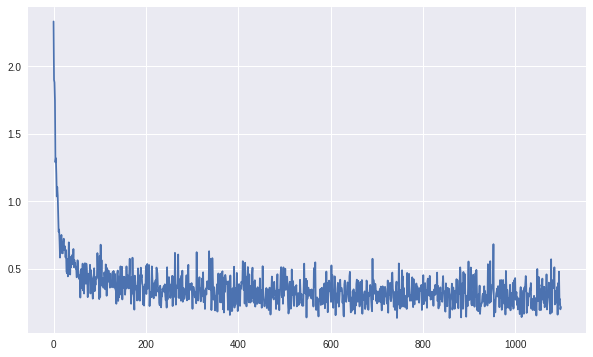

In [0]:
# plot losses
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [0]:
# show evaluation accuracy
print(get_accuracy(mnist.test.images,mnist.test.labels))

91.91%


prediction: 2 answer: 2
0 0.25%
1 0.0%
2 97.97%
3 0.23%
4 0.0%
5 0.43%
6 1.04%
7 0.0%
8 0.08%
9 0.0%


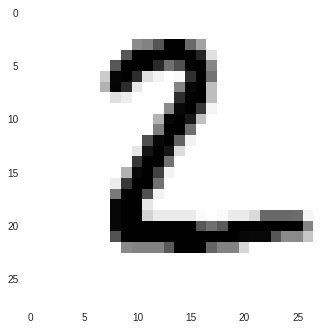

prediction: 6 answer: 6
0 0.16%
1 0.02%
2 2.8%
3 0.34%
4 0.11%
5 0.08%
6 88.85%
7 0.0%
8 7.6%
9 0.03%


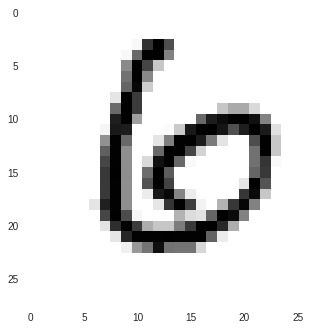

In [0]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x = Variable(torch.Tensor(mnist.test.images[test_idx].reshape(1,-1))).type(dtype)
    test_y = mnist.test.labels[test_idx]

    _prediction = net(test_x)

    print('prediction:', np.argmax(_prediction.cpu().data.numpy()), 'answer:', test_y)

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(float(100*np.exp(val)/np.sum(np.exp(_prediction))),2))+'%')

    plt.imshow(test_x.cpu().data.numpy().reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()